<a href="https://colab.research.google.com/github/narayanadhavala/ML-Projects/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
This Project aims to implement a CNN using the PyTorch deep learning framework.

**Overview:**
- Data Processing:
    - Data Normalization/Standardization
    - Data Augmentation
- Architectures:
    - Design and train a CNN model
    - Regularization
        - Dropout
        - L2 Norm
        - etc.
- Hyperparameter tuning:
    - Learning rate:
        - Tried at least **three different** learning rates.
    - Optimizer:
        - Tried at least **three different** optimizers, e.g. *SGD, RMSprop, Adam* and *etc*.

## 1 - Packages
Import the necessary packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
%matplotlib inline

!pip install utils
import utils

from sklearn.metrics import f1_score

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=7dee61153256f554cf271478da99e03c07ca5e8057c370550b88758e260122b5
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


## 2 - Training Parameters
Defined some hyper-parameters for the training process. Try changing these hyper-parameters and observe the performance of the model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # using gpu or cpu
print(f"Device:\t {device}")
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
num_classes = 10 # number of classes
batch_size = 100
num_epochs = 20 # to get a better result, you can increase the number of epochs

learning_rate = 0.001 # suggested range [1e-2, 1e-4]


Device:	 cuda


## 3 - Data Loader and Augmentation [5 points]
We will use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) as our dataset. Pytorch provide functions to download this dataset, we don't have to do download it from the official website. In this section, we will become familiar with the data loading pipeline of PyTorch.

- Normalize all the images to help remove gross bias within the data and to place us numerically within a known range for any input data.

- Implement data augmentations for the training references are ([here](https://pytorch.org/vision/stable/transforms.html)):
    - RandomCrop, RandomHorizontalFlip, RandomRotation, etc.
    
- More information is [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [ ]:
# Data augmentation
transform_train = transforms.Compose([
    ### START CODE HERE ### (≈ 3 lines of code)
    # Fill in data augmentations
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    ### END CODE HERE ###
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Don't augment the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [01:55<00:00, 1.47MB/s]


## 4 - Define the Networks [15 points]
This section defines the architecture of the CNN network. We provide the output dimension of each layer's output. Use this information to define the appropriate convolutional, max pooling and fully-connected (linear) layers in PyTorch. There might be multiple solutions to achieve the specified dimensions; it is required that the number of parameters in the network cannot exceed 3 million. Here, m denotes the batch size. The forward pass is also defined.

- Input: (m, 3, 32, 32)
- After ``conv1``: (m, 64, 16, 16)
- After ``maxpool1``: (m, 64, 8, 8)
- After ``conv2``: (m, 192, 8, 8)
- After ``maxpool2``: (m, 192, 4, 4)
- After ``conv3``: (m, 384, 4, 4)
- After ``maxpool3``: (m, 384, 2, 2)
- After ``conv4``: (m, 256, 2, 2)
- After ``maxpool4``: (m, 256, 1, 1)
- After ``fc1``: (m, 512)
- After ``fc2``: (m, 512)
- After ``fc3`` (Output): (m, 10)

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1_input_size = 256 * 1 * 1

        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def observe_outputs(self, x): # used to observe the dimension of each layer's output
        x = self.conv1(x)
        print(f'After conv1: {x.size()}')
        x = self.maxpool1(F.relu(x))
        print(f'After maxpool1: {x.size()}')

        x = self.conv2(x)
        print(f'After conv2: {x.size()}')
        x = self.maxpool2(F.relu(x))
        print(f'After maxpool2: {x.size()}')

        x = self.conv3(x)
        print(f'After conv3: {x.size()}')
        x = self.maxpool3(F.relu(x))
        print(f'After maxpool3: {x.size()}')

        x = self.conv4(x)
        print(f'After conv4: {x.size()}')
        x = self.maxpool4(F.relu(x))
        print(f'After maxpool4: {x.size()}')

        # flatten to a vector
        print(f'Flatten: {x.size()}')
        x = x.view(x.size(0), -1)
        #x = x.view(x.size(0), 256)
        print(f'Flatten: {x.size()}')

        x = F.relu(self.fc1(x))
        print(f'After fc1: {x.size()}')
        x = F.relu(self.fc2(x))
        print(f'After fc2: {x.size()}')
        x = self.fc3(x)
        print(f'After fc3: {x.size()}')
        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(F.relu(x))

        x = self.conv2(x)
        x = self.maxpool2(F.relu(x))

        x = self.conv3(x)
        x = self.maxpool3(F.relu(x))

        x = self.conv4(x)
        x = self.maxpool4(F.relu(x))

        # flatten to a vector
        x = x.view(x.size(0), 256)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


Run the block of code below to confirm each layer's output dimension matches the requirements.

In [ ]:
def test_forward(): # This function displays each layer's output dimension
    model = Model().to(device)
    x = torch.randn(16, 3, 32, 32).to(device)
    with torch.no_grad():
        model.observe_outputs(x)

test_forward()


After conv1: torch.Size([16, 64, 16, 16])
After maxpool1: torch.Size([16, 64, 8, 8])
After conv2: torch.Size([16, 192, 8, 8])
After maxpool2: torch.Size([16, 192, 4, 4])
After conv3: torch.Size([16, 384, 4, 4])
After maxpool3: torch.Size([16, 384, 2, 2])
After conv4: torch.Size([16, 256, 2, 2])
After maxpool4: torch.Size([16, 256, 1, 1])
Flatten: torch.Size([16, 256, 1, 1])
Flatten: torch.Size([16, 256])
After fc1: torch.Size([16, 512])
After fc2: torch.Size([16, 512])
After fc3: torch.Size([16, 10])


Run the block of code below to confirm the network has fewer than 30 millions parameters.

In [ ]:
def count_parameters(net, all=True):
    # If all == False, we only return the trainable parameters
    return sum(p.numel() for p in net.parameters() if p.requires_grad or all)

num_params = count_parameters(Model())
print(f'Total number of parameters: {num_params}')


Total number of parameters: 2260554


## 5 - Loss and Optimizer
This section initializes the ``Model`` class, and defines the loss function and optimizer. I did multi-class classification, so we use the cross-entropy loss. The standard optimizers are Stochastic Gradient Descent (SGD) and Adam. Information about optimisers are [here](https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer).

In [ ]:
# initialize the model and send it to GPU using torch.Tensor.to()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

# initialize cross-entropy loss
criterion = nn.CrossEntropyLoss()

# initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## 6 - Define the Training Loop
This section contains how to train the model: get batches, calculate loss, and update model.

A standard PyTorch training loop consists of:

- Getting the prediction for each batch.
- Calculate the loss on the prediction versus the true label (ground truth).
- Calculate the gradients.
- Update the model's weights/parameters using the optimizer and the gradients computed in the previous step.

Also,

- Keep track of the loss values to plot the training loss later
- Clear out the old gradients in the optimizer every iteration before calculating the new ones.
- Frequently print out the accuracy of the model to see if the learning is on the right track.

In [ ]:
# Train the model
def train(epoch):
    print('\nEpoch: %d' % epoch)
    train_losses = [] # needed for visualize the traning loss
    train_accs=[]
    model.train()
    train_loss = 0
    train_acc = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)# get a batch
        ### START CODE HERE ### (≈ 5 lines of code)
        # Clear gradient
        optimizer.zero_grad()

        # Forward pass batch through model
        outputs = model(inputs)
        # Calculate loss on batch
        loss = criterion(outputs, targets)

        # Calculate gradients for backward pass
        loss.backward()

        # Update model
        optimizer.step()

        ### END CODE HERE ###

        train_loss += loss.item()
        train_losses.append(loss.item())
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        train_acc = 100.*correct/total
        train_accs.append(train_acc)
        if batch_idx % 100 == 0: # print every 100 iterations
            print(batch_idx, len(trainloader), 'Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_losses,train_accs


## 7 - Define the Testing Loop
This section contains how to test the trained model and save the best model.

A standard PyTorch testing loop consists of:

- Getting the predictions and calculate the accuracy over the whole testing set.

Also,

- Disable the gradients on the model upon making predictions (i.e., ``torch.no_grad()``).
- Save the best model's weights ([reference](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).

In [ ]:
def test(epoch):
    global best_acc
    test_losses = []
    test_accs = []
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            ### START CODE HERE ### (≈ 2 lines of code)
            # Forward pass batch through model
            outputs= model(inputs)
            # Calculate loss on batch
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_losses.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            test_acc = 100.*correct/total
            test_accs.append(test_acc)
            if batch_idx % 100 == 0:
                print(batch_idx, len(testloader), 'Testing Loss: %.3f | Acc: %.3f%% (%d/%d)'
                            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save best model.
    acc = 100.*correct/total
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))
    if acc > best_acc:
        print('Start Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        print('Done Saving!')
    return test_losses, test_accs


## 8 - Model Training and Testing

Run the training and testing loops to conduct the training process.

In [ ]:
for epoch in range(start_epoch, start_epoch + num_epochs):
    l_tr, A_tr = train(epoch)
    l_te, A_te = test(epoch)



Epoch: 0
0 500 Train Loss: 2.303 | Acc: 8.000% (8/100)
100 500 Train Loss: 2.047 | Acc: 22.455% (2268/10100)
200 500 Train Loss: 1.928 | Acc: 26.303% (5287/20100)
300 500 Train Loss: 1.836 | Acc: 29.641% (8922/30100)
400 500 Train Loss: 1.775 | Acc: 32.217% (12919/40100)
0 100 Testing Loss: 1.380 | Acc: 55.000% (55/100)
Test Accuracy of the model on the 10000 test images: 47.16 %
Start Saving..
Done Saving!

Epoch: 1
0 500 Train Loss: 1.583 | Acc: 44.000% (44/100)
100 500 Train Loss: 1.455 | Acc: 46.020% (4648/10100)
200 500 Train Loss: 1.447 | Acc: 46.274% (9301/20100)
300 500 Train Loss: 1.434 | Acc: 47.186% (14203/30100)
400 500 Train Loss: 1.419 | Acc: 47.711% (19132/40100)
0 100 Testing Loss: 1.129 | Acc: 58.000% (58/100)
Test Accuracy of the model on the 10000 test images: 54.21 %
Start Saving..
Done Saving!

Epoch: 2
0 500 Train Loss: 1.163 | Acc: 56.000% (56/100)
100 500 Train Loss: 1.295 | Acc: 52.455% (5298/10100)
200 500 Train Loss: 1.288 | Acc: 53.070% (10667/20100)
300 50

## Evaluation from Checkpoint (Optional)
This section will show you how to load the saved model.

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

checkpoint = torch.load('./checkpoint/ckpt.pth') # load checkpoint
model.load_state_dict(checkpoint['net']) # load model parameter

model.eval()
test_loss = 0
correct = 0
total = 0
all_targets = []
all_predictions = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        ### START CODE HERE ### (≈ 2 lines of code)
        # Forward pass real batch through model
        outputs= model(inputs)
        # Calculate loss on all-real batch
        loss = criterion(outputs, targets)
        ### END CODE HERE ###

        test_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
acc = 100.*correct/total
print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))

f1 = f1_score(all_targets, all_predictions, average='weighted')
print('F1 Score: {:.2f}'.format(f1))


Test Accuracy of the model on the 10000 test images: 75.28 %
F1 Score: 0.75


## Extra - Plot the Training Loss  

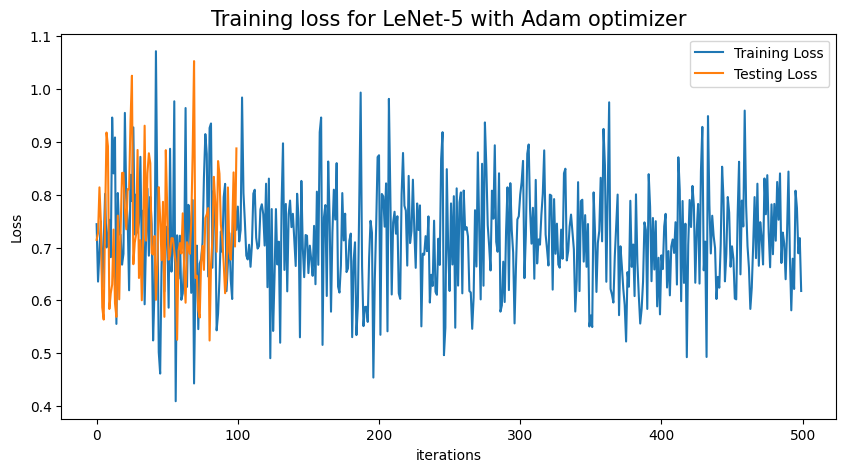

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.title("Training loss for LeNet-5 with Adam optimizer", fontsize=15)
plt.plot(l_tr,label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
""" ax.text(0.7, 0.7,'Test ACC: 64.35%; lr=1e-3',
      horizontalalignment='center',
      verticalalignment='center',
      transform = ax.transAxes,
      fontsize=20, color='red') """
plt.plot(l_te,label="Testing Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


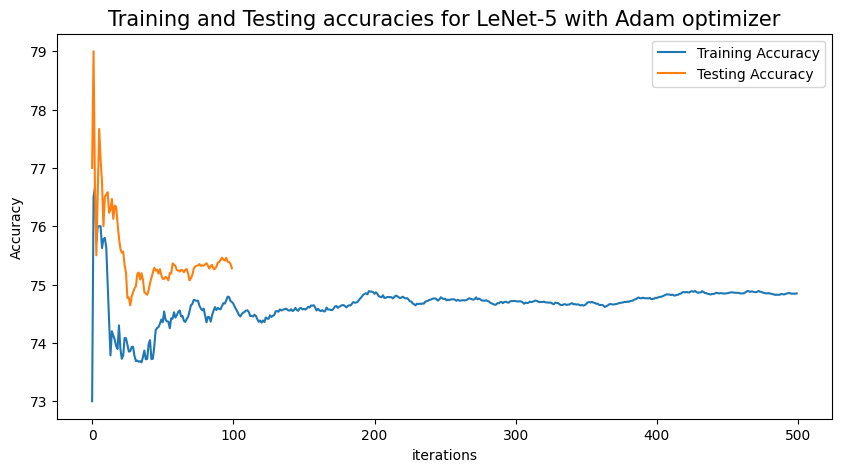

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.title("Training and Testing accuracies for LeNet-5 with Adam optimizer", fontsize=15)
plt.plot(A_tr,label="Training Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.plot(A_te,label="Testing Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
